In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [3]:
import scanpy as sc
import numpy as np 
# import anndata as ad
# import pandas as pd
import yaml

## Data prep

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset1/"

Single-cell preprocessed data of ‘Sample 21’ in MouseGastrulationData within the R/Bioconductor data package `MouseGastrulationData`, containing: normalized counts, cell metadata including cell type annotation.

In [ ]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4651 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'X_name'

In [10]:
print("Count format: ", adata_sc.uns['X_name'])
adata_sc.obs.head()

Count format:  counts


,cell,barcode,sample,pool,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,cluster.theiler,stripped,celltype,colour
cell_52466,cell_52466,AAACATACACGGAG,21,17,mixed_gastrulation,2,TS9-10,0.031554,False,14,2,5,5,False,Blood progenitors 2,c9a997
cell_52467,cell_52467,AAACATACCCAACA,21,17,mixed_gastrulation,2,TS9-10,0.136242,False,3,6,12,12,False,ExE ectoderm,989898
cell_52468,cell_52468,AAACATACTTGCGA,21,17,mixed_gastrulation,2,TS9-10,0.746898,False,2,3,3,3,False,Epiblast,635547
cell_52469,cell_52469,AAACATTGATCGGT,21,17,mixed_gastrulation,2,TS9-10,0.270453,False,1,3,1,1,False,Rostral neurectoderm,65A83E
cell_52470,cell_52470,AAACATTGCTTATC,21,17,mixed_gastrulation,2,TS9-10,0.222604,False,19,1,5,5,False,Haematoendothelial progenitors,FBBE92


ST data of seqFISH experiment on Mouse Gastrulation tissue with ID, spatial coordinates, metadata including cell type annotation.

In [ ]:
adata_st = sc.read(data_path + "seqFISH_data.h5ad")  # .obsm['spatial'] contains affine coordinates
adata_st

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

The coordinates saved in `adata_st.obsm['spatial']` are obtained as `adata_st.obs[['x_global_affine', 'y_global_affine']].to_numpy()`.

#### CT Annotations

In [11]:
print("scRNA cell types: \n", adata_sc.obs['celltype'].unique())
print("Spatial data cell types: \n", adata_st.obs['celltype_mapped_refined'].unique())
common_cts = set(adata_sc.obs['celltype'].unique()) & set(adata_st.obs['celltype_mapped_refined'].unique())
print("Common cell types: \n", common_cts)
print("Length:", len(common_cts))

scRNA cell types: 
 ['Blood progenitors 2', 'ExE ectoderm', 'Epiblast', 'Rostral neurectoderm', 'Haematoendothelial progenitors', ..., 'Visceral endoderm', 'Surface ectoderm', 'Intermediate mesoderm', 'Somitic mesoderm', 'Allantois']
Length: 29
Categories (28, object): ['Allantois', 'Anterior Primitive Streak', 'Blood progenitors 1', 'Blood progenitors 2', ..., 'Rostral neurectoderm', 'Somitic mesoderm', 'Surface ectoderm', 'Visceral endoderm']
Spatial data cell types: 
 ['Low quality', 'Lateral plate mesoderm', 'Erythroid', 'Allantois', 'Gut tube', ..., 'Anterior somitic tissues', 'Presomitic mesoderm', 'Dermomyotome', 'Cardiomyocytes', 'Sclerotome']
Length: 24
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']
Common cell types: 
 {'Intermediate mesoderm', 'Haematoendothelial progenitors', 'ExE endoderm', 'Allantois', 'Surface ectoderm'}
Length: 5


#### Spatial data sub-sampling
In the benchmarking paper the total number of spots is $8425$, despite the full seqFISH data having $57535$ spots.
The subsampling pattern, based on the comparison of the first 4 spatial coordinates in `Locations.txt`, seems to be that the $i$-th spot in the subset corresponds to the $2i+1$-th spot in the original set, but the pattern brakes in the last 4 values at least.

We also check whether the subset sub-sampling is related to spatial information, such as the position in the sample:

In [12]:
# Check #spots per position and cumulative sum
cum_sum = 0
for pos_num in np.linspace(0,adata_st.obs['pos'].nunique(),adata_st.obs['pos'].nunique()+1, dtype='int'):
    len = adata_st.obs.loc[adata_st.obs['pos'] == f'Pos{pos_num}'].shape[0]
    cum_sum += len
    print(f"Pos{pos_num}: {len}, cumulative sum = {cum_sum}")

Pos0: 1301, cumulative sum = 1301
Pos1: 1416, cumulative sum = 2717
Pos2: 1324, cumulative sum = 4041
Pos3: 1399, cumulative sum = 5440
Pos4: 1204, cumulative sum = 6644
Pos5: 1526, cumulative sum = 8170
Pos6: 1683, cumulative sum = 9853
Pos7: 1317, cumulative sum = 11170
Pos8: 1172, cumulative sum = 12342
Pos9: 1081, cumulative sum = 13423
Pos10: 1354, cumulative sum = 14777
Pos11: 906, cumulative sum = 15683
Pos12: 941, cumulative sum = 16624
Pos13: 1021, cumulative sum = 17645
Pos14: 760, cumulative sum = 18405
Pos15: 1682, cumulative sum = 20087
Pos16: 1300, cumulative sum = 21387
Pos17: 1481, cumulative sum = 22868
Pos18: 1308, cumulative sum = 24176
Pos19: 996, cumulative sum = 25172
Pos20: 1531, cumulative sum = 26703
Pos21: 920, cumulative sum = 27623
Pos22: 615, cumulative sum = 28238
Pos23: 1391, cumulative sum = 29629
Pos24: 711, cumulative sum = 30340
Pos25: 1435, cumulative sum = 31775
Pos26: 1148, cumulative sum = 32923
Pos27: 1678, cumulative sum = 34601
Pos28: 1444, cum

Since no partial sum matches the target number, spots are not subsampled based on spatial position, but rather on an inexplicable pattern.
We subset taking the first $8425$ spots to maintain the original sample size:

In [12]:
# Subset to first 8425 spots
adata_st = adata_st[0:8425]
adata_st

View of AnnData object with n_obs × n_vars = 8425 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

In [ ]:
# write reduced dataset
sc.write(filename=data_path + "seqFISH_data.h5ad", adata=adata_st, ext='h5ad')

# Data Loading

In [5]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 4651 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'X_name'

In [6]:
adata_st = sc.read(data_path + "seqFISH_data.h5ad")  # .obsm['spatial'] contains affine coordinates
adata_st

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

In [7]:
adata_st.obs['pos']

embryo1_Pos0_cell10_z2      Pos0
embryo1_Pos0_cell10_z5      Pos0
embryo1_Pos0_cell100_z2     Pos0
embryo1_Pos0_cell100_z5     Pos0
embryo1_Pos0_cell101_z2     Pos0
                           ...  
embryo3_Pos39_cell95_z5    Pos39
embryo3_Pos39_cell96_z5    Pos39
embryo3_Pos39_cell97_z2    Pos39
embryo3_Pos39_cell98_z5    Pos39
embryo3_Pos39_cell99_z2    Pos39
Name: pos, Length: 57536, dtype: category
Categories (51, object): ['Pos0', 'Pos1', 'Pos2', 'Pos3', ..., 'Pos47', 'Pos48', 'Pos49', 'Pos50']

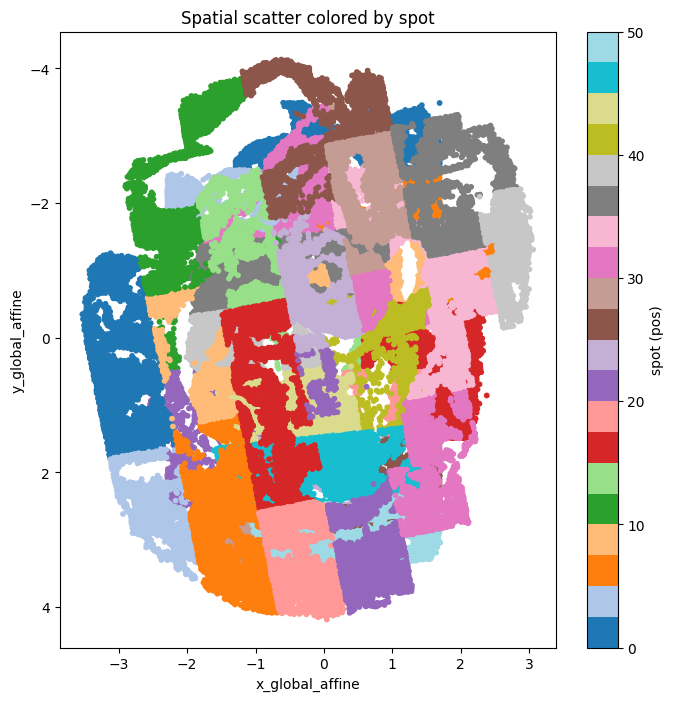

In [8]:
# x and y coordinates (affine)
import matplotlib.pyplot as plt
x = adata_st.obs['x_global_affine']
y = adata_st.obs['y_global_affine']

# color by spot (pos)
colors = adata_st.obs['pos']

plt.figure(figsize=(8,8))
scatter = plt.scatter(x, y, c=colors.astype('category').cat.codes, cmap='tab20', s=10)
plt.xlabel('x_global_affine')
plt.ylabel('y_global_affine')
plt.title('Spatial scatter colored by spot')
plt.gca().invert_yaxis()  # optional, for typical tissue orientation
plt.colorbar(scatter, label='spot (pos)')
plt.show()

In this case it might be interesting to map per position or chunk of positions in order to make a more spatially apeare mapping, and perhaps harmonize labels per pos.

In [11]:
adata_st = adata_st[adata_st.obs['pos'] == 'Pos0']
adata_st

View of AnnData object with n_obs × n_vars = 1301 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

# Config

In [16]:
# Read config yaml
with open("data/Dataset1/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed

{'cluster_label': 'celltype',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

## Train/val split

In [13]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

280 training genes:  ['soat2' 'erg' 'cbfa2t3' 'sp5' 'gfi1b' 'itga4' 'tmem108' 'ptprc' 'lmo2'
 'shh'] ...
70 validation genes:  ['dkk1' 'tfap2a' 'igfbp3' 'epor' 'pax6' 'bid' 'podxl' 'pou3f1' 'tbx3'
 'ep300'] ...


# Model training

In [17]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 70 genes
S matrix shape: torch.Size([3661, 70])
G matrix shape: torch.Size([1301, 70])

Validation 0: {'val_score': 0.4250827729701996, 'val_sparsity-weighted_score': 0.006823433097451925, 'val_AUC': 0.5375935435295105, 'val_entropy': 0.930533230304718}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 275 genes
S matrix shape: torch.Size([3661, 275])
G matrix shape: torch.Size([1301, 275])


Trainig:   0%|          | 1/1000 [00:08<2:17:30,  8.26s/it]

Epoch 0: {'loss': -3.4499590396881104, 'main_loss': 0.43076109886169434, 'vg_reg': 0.25750598311424255, 'kl_reg': 2.3424999540111457e-07, 'entropy_reg': -2.442893492116127e-05, 'l1_term': 3.800192605041275e-09, 'l2_term': 4.763144739738934e-12, 'sparsity_term': 0.4875744581222534, 'neighborhood_term': 0.6010321378707886, 'getis_ord_term': 0.6849168539047241, 'moran_term': 0.0018184519140049815, 'geary_term': 0.9863764047622681, 'ct_island_term': 1.757087147780112e-06}


Trainig:   5%|▌         | 50/1000 [07:09<2:15:09,  8.54s/it]


Validation 49: {'val_score': 0.4835476577281952, 'val_sparsity-weighted_score': 0.007909084670245647, 'val_AUC': 0.5839634537696838, 'val_entropy': 0.6860424876213074}


Trainig:  10%|█         | 100/1000 [14:18<2:08:43,  8.58s/it]


Validation 99: {'val_score': 0.45149093866348267, 'val_sparsity-weighted_score': 0.007466347888112068, 'val_AUC': 0.5599083304405212, 'val_entropy': 0.43896305561065674}


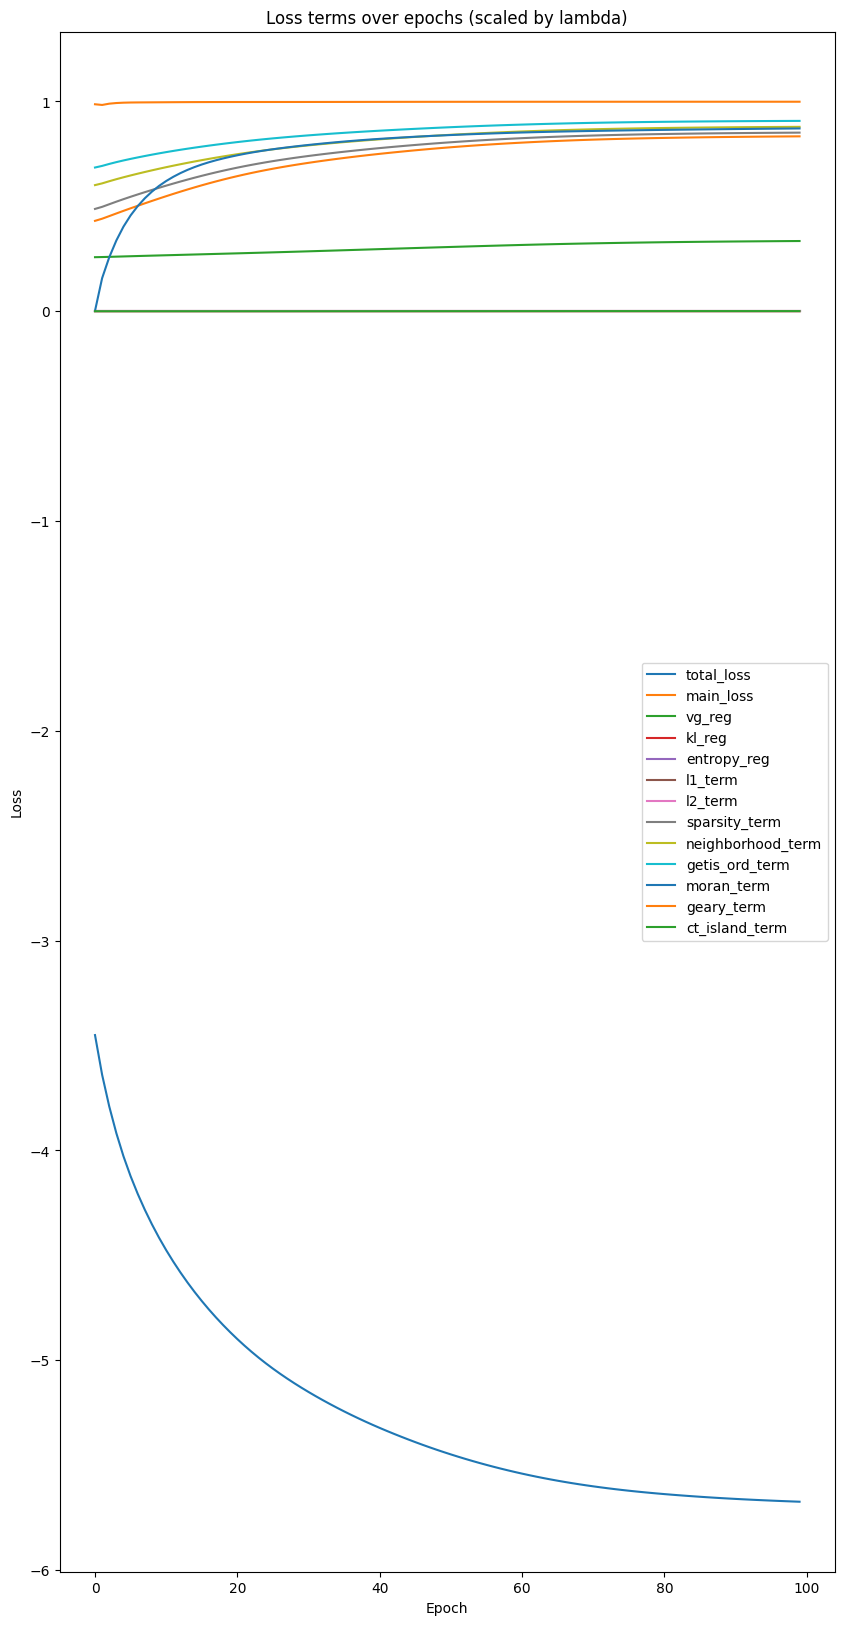

In [18]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

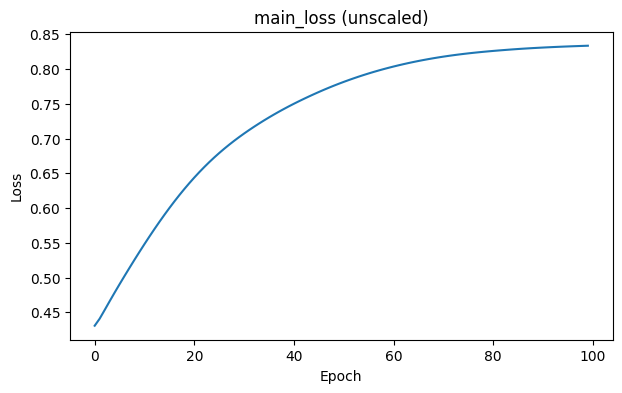

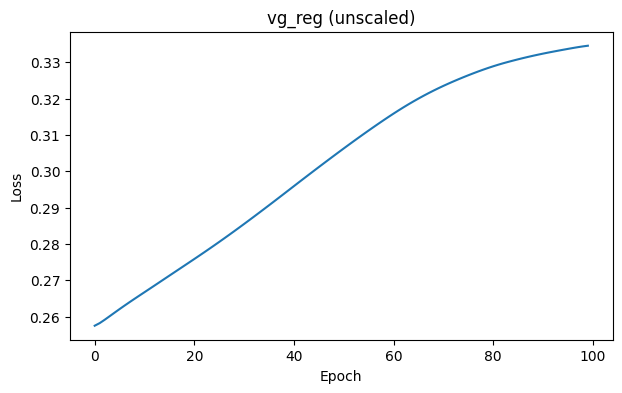

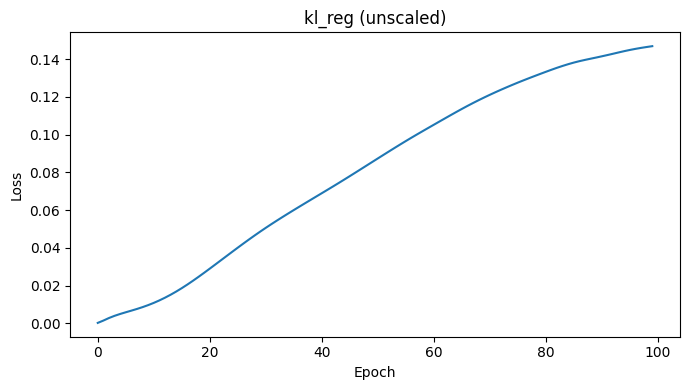

In [19]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

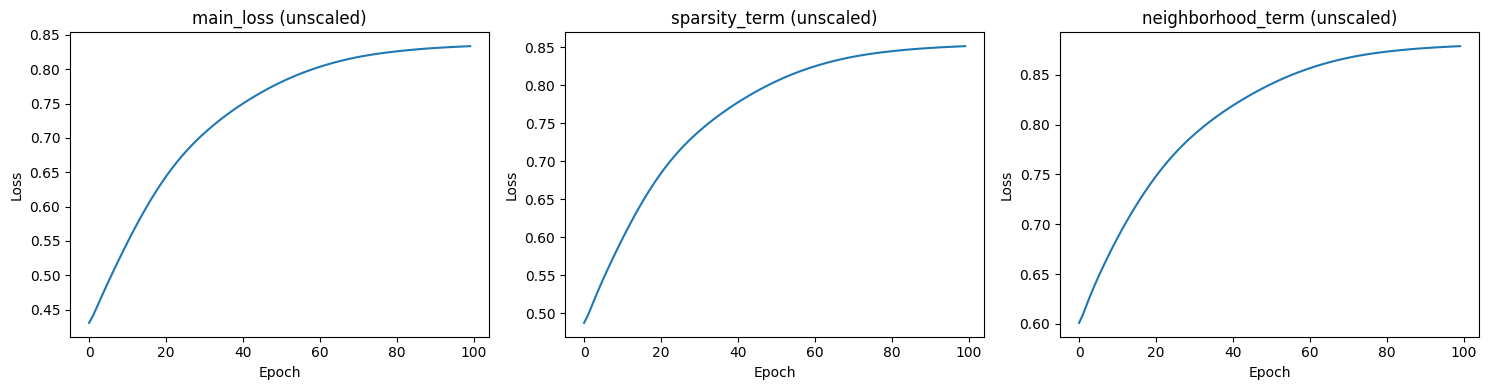

In [20]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

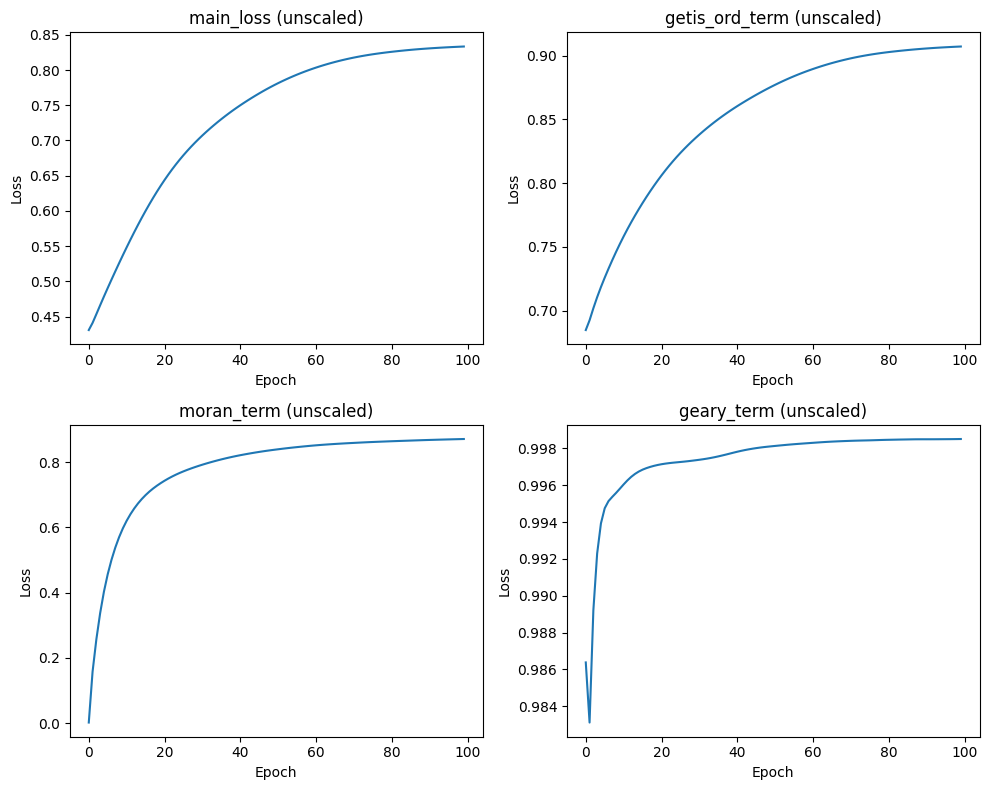

In [21]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

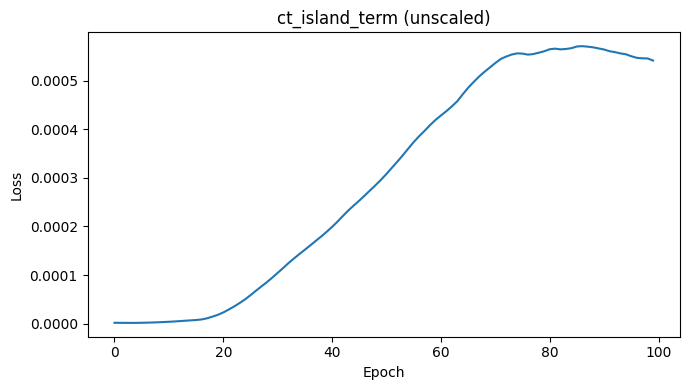

In [22]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

# Validation

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


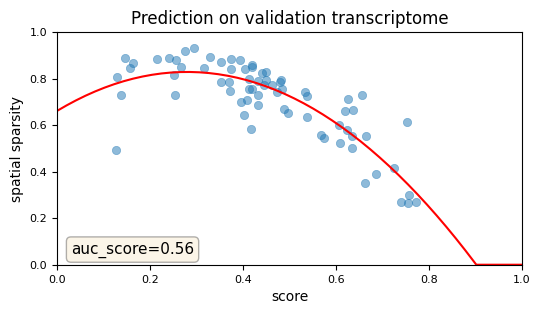

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.5599083304405212      │
│           val_JS            │     0.36161187291145325     │
│           val_PCC           │     0.24952177703380585     │
│          val_RMSE           │     1.2174111604690552      │
│          val_SSIM           │     0.19892218708992004     │
│         val_entropy         │     0.43896305561065674     │
│          val_score          │     0.45149093866348267     │
│ val_sparsity-weighted_score │    0.007466347888112068     │
└─────────────────────────────┴─────────────────────────────┘

In [23]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

# Sparsity

In [24]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 1301 × 29452
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'ENSEMBL', 'SYMBOL', 'sparsity', 'is_training'
    uns: 'X_name', 'overlap_genes', 'training_genes'

In [25]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

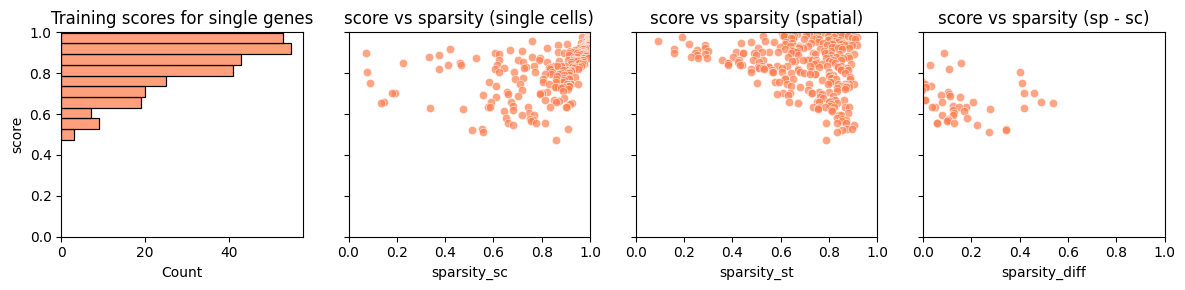

In [26]:
# Plot training scores panels
tgl.plot_training_scores(df)

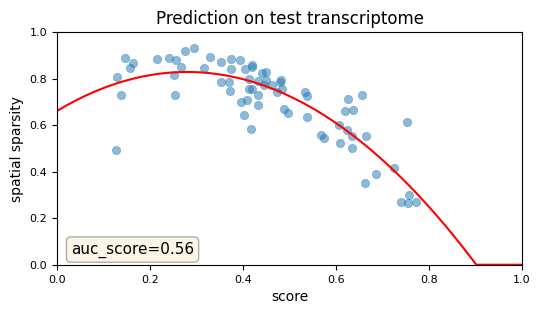

In [27]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [28]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset1', adata=ad_map, ext='h5ad')